In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchvision.io import read_image

import torchvision
import torchvision.models as models
import torch
import os

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Pad, Compose,CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize, transforms
from torch.utils.data import DataLoader
from torch.functional import F

import matplotlib.pyplot as plt
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [127]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ]),
}

In [128]:

#######################################################
#               Define Dataset Class
#######################################################

class LineDataset(Dataset):
    def __init__(self, annotations_file, image_paths, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[["Path","ClassId"]]
        self.image_paths = image_paths
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_filepath = os.path.join(self.image_paths, self.img_labels.iloc[idx, 0])
        label = self.img_labels.iloc[idx, 1]

        image = read_image(image_filepath)
    
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

dataset = LineDataset("Dataset/Line_annotation.csv","Dataset", transform = data_transforms["train"])

dataset =torch.utils.data.random_split(dataset,[0.7,0.3]) 

dataset_loader = {
    "train" : DataLoader(dataset[0], batch_size=1, shuffle=True),
    "test" : DataLoader(dataset[1], batch_size=1, shuffle=True)

}


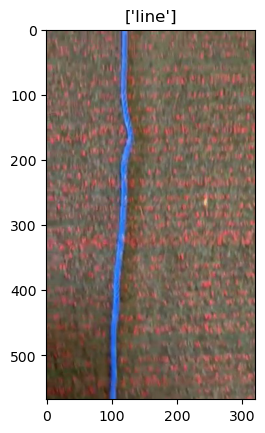

In [129]:
class_names={1 :"line"}
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataset_loader["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])


In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataset_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataset_loader[phase])
            epoch_acc = running_corrects.double() / len(dataset_loader[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(best_model_wts, "Models/best_model2")
    return model

In [131]:
model_ft = models.mobilenet_v3_small(pretrained=True)
#wideresnet.eval()

model_ft.classifier[-1] = nn.Linear(1024, 2)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

models.detection.mov

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [132]:
def score_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct =0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataset_loader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if class_names[preds[j].item()] == class_names[labels[j].item()]:
                    correct += 1 
                    
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print("Accuracy: ",correct/num_images)
                    return
        model.train(mode=was_training)

In [134]:

torch.save(copy.deepcopy(model_ft.state_dict()), "Models/best_model2")


In [133]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0042 Acc: 0.9988
test Loss: 0.0110 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.0003 Acc: 1.0000
test Loss: 0.0077 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.0002 Acc: 1.0000
test Loss: 0.0064 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0053 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0045 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0040 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0038 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0041 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0040 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0043 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0039 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0001 Acc: 1.0000
test Loss: 0.0039 Acc

RuntimeError: Parent directory Models does not exist.

In [1]:
model_ft.load_state_dict(torch.load("Models/best_model2"))
score_model(model_ft, 1000)

NameError: name 'model_ft' is not defined